# Training Pipeline
Selects features, creates training data, trains and saves model

## Imports

In [24]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import hopsworks
from xgboost import XGBRegressor
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [2]:
import os
from pathlib import Path
import sys
from dotenv import load_dotenv

root_dir = Path().absolute()
# Strip subdirectories if the notebook started in any
if root_dir.parts[-1:] == ('pipeline',):
    root_dir = Path(*root_dir.parts[:-1])
if root_dir.parts[-1:] == ('src',):
    root_dir = Path(*root_dir.parts[:-1])
root_dir = str(root_dir) 

os.chdir(root_dir)
print(f"Root dir: {Path.cwd()}")

from src.data_utils.ingest import *

load_dotenv()
hopsworks_key = os.getenv('HOPSWORKS_API_KEY')

Root dir: /Users/serkan/ID2223-project


## Connect to Hopsworks Feature Store

In [3]:
if hopsworks_key is not None:
    os.environ['HOPSWORKS_API_KEY'] = hopsworks_key

# If you are invited to someone else's Hopsworks project, write that project's name below
project_name = None

if project_name:
    project = hopsworks.login(project=f'{project_name}')
else:
    project = hopsworks.login()
    
fs = project.get_feature_store()

# Set up secrets here
secrets = hopsworks.get_secrets_api()
# ...
# ...
# ...

2026-01-03 15:07:08,814 INFO: Initializing external client
2026-01-03 15:07:08,815 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-03 15:07:09,411 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-03 15:07:10,636 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1330333


### Retrieve Feature groups

In [4]:
features_fg = fs.get_feature_group(
    name="delay_features_fg",
    version=1
)

labels_fg = fs.get_feature_group(
    name="delay_labels_fg",
    version=1
)

features_df = features_fg.read(online=True)
labels_df = labels_fg.read(online=True)

In [ ]:
## print info
print("features_df info: ")
print(features_df.info())
print()
print(labels_df.info())

### Merge features and labels into a df

In [5]:
HORIZON = pd.Timedelta(minutes=20)
TOLERANCE = pd.Timedelta(minutes=20)

In [6]:
features_df = features_df.reset_index(drop=True)
labels_df = labels_df.reset_index(drop=True)

In [7]:
features_df = features_df.sort_values(["line", "timestamp"])
labels_df = labels_df.sort_values(["line", "timestamp"])

In [8]:
features_df["target_time"] = features_df["timestamp"] + HORIZON

In [9]:
features_df = features_df.sort_values(["line", "target_time"])
labels_df = labels_df.sort_values(["line", "timestamp"])

features_df = features_df.reset_index(drop=True)
labels_df = labels_df.reset_index(drop=True)

In [10]:
lines = features_df['line'].unique()
merged_list = []
for line in lines:
    features_line = features_df[features_df['line'] == line].sort_values("target_time")
    labels_line = labels_df[labels_df['line'] == line].sort_values("timestamp")
    merged_line = pd.merge_asof(
        features_line,
        labels_line,
        left_on="target_time",
        right_on="timestamp",
        direction="forward",
        tolerance=TOLERANCE,
        suffixes=("_feat", "_label")
    )
    merged_list.append(merged_line)

train_df = pd.concat([merged_list[0], merged_list[1], merged_list[2]], ignore_index=True)
# print(train_df.info())
# print(train_df.head(10))

In [11]:
train_df = train_df.rename(columns={
    "timestamp_feat": "timestamp",
    "avg_delay": "target", 
    "line_feat": "line",
})

train_df = train_df.drop(columns=[
    "timestamp_str_feat",
    "target_time",
    "timestamp_label",
    "timestamp_str_label"
])

train_df = train_df[["timestamp", "line", "delay_60", "delay_30", "delay_current", "target"]]

In [ ]:
print(train_df.iloc[40])

### Drop rows with nan values

In [ ]:
print(train_df.isna().sum())

In [12]:
train_df = train_df.dropna(subset=['target'])

In [13]:
train_df = train_df.dropna(subset=["delay_60"])

In [ ]:
print(train_df.isna().sum())

### Add day as feature

In [14]:
train_df["day"] = train_df["timestamp"].dt.day_name()

In [15]:
train_df = train_df[["timestamp", "line", "day", "delay_60", "delay_30", "delay_current", "target"]]

In [ ]:
print(train_df.info())

### Encode line and day using LabelEncoder

In [16]:
line_encoder = LabelEncoder()
train_df["line_encoded"] = line_encoder.fit_transform(train_df["line"])

days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_encoder = LabelEncoder()
day_encoder.fit(days_of_week)
train_df["day_encoded"] = day_encoder.transform(train_df["day"])

if not os.path.exists(Path("model")):
    os.makedirs("model", exist_ok=True)

joblib.dump(line_encoder, "model/line_encoder.pkl")
joblib.dump(day_encoder, "model/day_encoder.pkl")

2026-01-03 15:07:47,961 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-03 15:07:47,962 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-03 15:07:47,964 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-03 15:07:47,964 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



['model/day_encoder.pkl']

In [17]:
train_df = train_df[["timestamp", "line_encoded", "day_encoded", "delay_60", "delay_30", "delay_current", "target"]]
print(train_df.head())

            timestamp  line_encoded  day_encoded   delay_60  delay_30  \
2 2025-12-30 22:42:00             0            5   3.285714   -21.250   
3 2025-12-30 23:21:00             0            5 -21.250000   -19.000   
5 2025-12-31 07:26:00             0            6 -42.000000   -32.250   
6 2025-12-31 07:54:00             0            6 -32.250000   -39.875   
7 2025-12-31 08:18:00             0            6 -39.875000   -38.375   

   delay_current  target  
2        -19.000 -42.000  
3        -42.000 -32.250  
5        -39.875 -38.375  
6        -38.375 -34.375  
7        -34.375 -45.125  


In [18]:
train_df["timestamp_str"] = train_df["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%S")

### Split data and train model

In [20]:
split_time = pd.Timestamp("2026-01-01 23:13:00")
train_data = train_df[train_df['timestamp'] < split_time]
test_data = train_df[train_df['timestamp'] >= split_time]

X_train = train_data.drop(columns=['target', 'timestamp', 'timestamp_str']).reset_index(drop=True)
y_train = train_data['target'].reset_index(drop=True)

X_test = test_data.drop(columns=['target', 'timestamp', 'timestamp_str']).reset_index(drop=True)
y_test = test_data['target'].reset_index(drop=True)

print(X_train)
print(y_train)

     line_encoded  day_encoded   delay_60   delay_30  delay_current
0               0            5   3.285714 -21.250000     -19.000000
1               0            5 -21.250000 -19.000000     -42.000000
2               0            6 -42.000000 -32.250000     -39.875000
3               0            6 -32.250000 -39.875000     -38.375000
4               0            6 -39.875000 -38.375000     -34.375000
..            ...          ...        ...        ...            ...
168             2            4 -14.222222 -14.277778     -22.947368
169             2            4 -14.277778 -22.947368     -28.000000
170             2            4 -22.947368 -28.000000     -16.578947
171             2            4 -28.000000 -16.578947     -22.315789
172             2            4 -16.578947 -22.315789     -27.444444

[173 rows x 5 columns]
0     -42.000000
1     -32.250000
2     -38.375000
3     -34.375000
4     -45.125000
         ...    
168   -28.000000
169   -16.578947
170   -22.315789
171   -

In [21]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.3f}, R^2: {r2:.3f}")


2026-01-03 15:09:07,839 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-03 15:09:07,839 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-03 15:09:07,840 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-03 15:09:07,840 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

Test MSE: 208.476, R^2: 0.852


In [22]:
mr = project.get_model_registry()
model_name = "xgb_regressor"
joblib.dump(xgb_model, "model/model.joblib")

model = mr.python.create_model(
    name=model_name,
    metrics={"mse": mse, "r2": r2},
    description="XGBoost regressor for metro delay prediction",
)

model.save("model")

2026-01-03 15:09:25,027 WARNING: ProvenanceWarning: Model schema cannot not be inferred without both the feature view and the training dataset version.



  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/serkan/ID2223-project/model/line_encoder.pkl: 0.000%|          | 0/517 elapsed<00:00 remainin…

Uploading /Users/serkan/ID2223-project/model/model.joblib: 0.000%|          | 0/229483 elapsed<00:00 remaining…

Uploading /Users/serkan/ID2223-project/model/day_encoder.pkl: 0.000%|          | 0/579 elapsed<00:00 remaining…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1330333/models/xgb_regressor/3


Model(name: 'xgb_regressor', version: 3)

### Plot of feature importance

2026-01-03 15:11:57,492 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



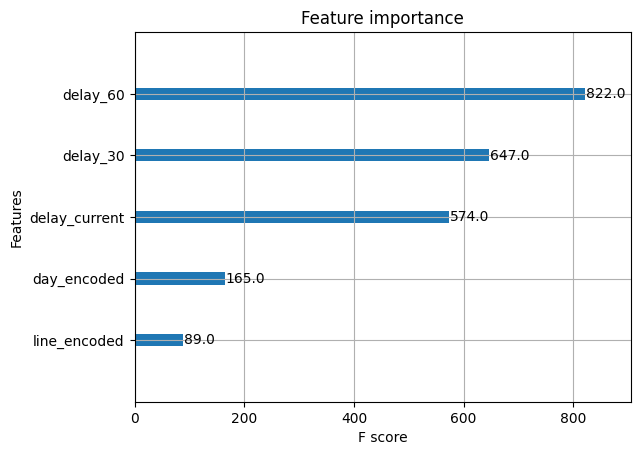

In [ ]:
plot_importance(xgb_model)
if not os.path.exists(Path("model/images")):
    os.mkdir(Path("model/images"))
feature_importance_path = Path("model/images/feature_importance.png")
plt.savefig(feature_importance_path)
plt.show()

### Model predictions vs true delays

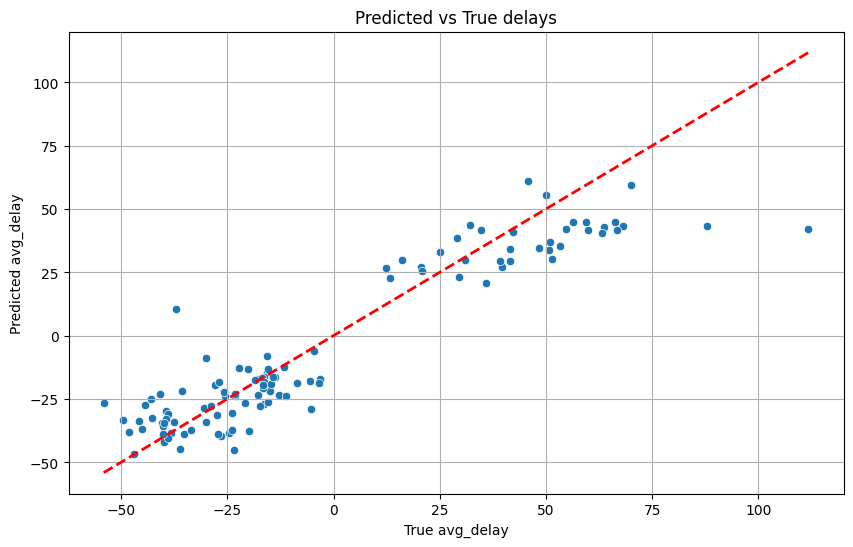

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True avg_delay")
plt.ylabel("Predicted avg_delay")
plt.title("Predicted vs True delays")
plt.grid(True)
plt.show()